### Installing neccessary libraries

In [ ]:
# TensorFlow
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# tf.config.run_functions_eagerly(True)

# Others
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt

import pydot
import seaborn as sb

: 

In [2]:
# Define AUTOTUNE for TensorFlow dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Data Preprocessing

In [3]:
# Define necessary variables
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 1500
VALID_SIZE = BATCH_SIZE * 1000
TEST_SIZE  = BATCH_SIZE * 600

# Training callbacks
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=MODEL_NAME + ".h5.keras", save_best_only=True)
]

# Paths
train_csv_path = r'D:\Projects\Handwritten OCR\Dataset\CSV\written_name_train.csv'
valid_csv_path = r'D:\Projects\Handwritten OCR\Dataset\CSV\written_name_validation.csv'
test_csv_path = r'D:\Projects\Handwritten OCR\Dataset\CSV\written_name_test.csv'
train_image_dir = r'D:\Projects\Handwritten OCR\Dataset\train_v2\train'
valid_image_dir = r'D:\Projects\Handwritten OCR\Dataset\validation_v2\validation'
test_image_dir = r'D:\Projects\Handwritten OCR\Dataset\test_v2\test'

# Setup random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [4]:
# Load the csv flies
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

In [5]:
# See how the data looks like
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [6]:
# Get the train labels
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

# #Extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)

# Define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

print("Number of unique classes (unique characters): ", n_classes)

Number of unique classes (unique characters):  44


In [7]:
# Get the maximum length that a label can have
MAX_LABEL_LENGTH = max(map(len, train_labels))

print("The length of the longest label in the dataset: ", MAX_LABEL_LENGTH)

The length of the longest label in the dataset:  24


In [8]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
test_csv['FILENAME'] = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]

In [9]:
train_csv.head()

,FILENAME,IDENTITY
0,D:\Projects\Handwritten OCR\Dataset\train_v2\t...,BALTHAZAR
1,D:\Projects\Handwritten OCR\Dataset\train_v2\t...,SIMON
2,D:\Projects\Handwritten OCR\Dataset\train_v2\t...,BENES
3,D:\Projects\Handwritten OCR\Dataset\train_v2\t...,LA LOVE
4,D:\Projects\Handwritten OCR\Dataset\train_v2\t...,DAPHNE


In [10]:
# Char to num
char_to_num = StringLookup(vocabulary = list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token=None, invert=True)

len(char_to_num.get_vocabulary()) + 1

46

In [11]:
'''
This function gets the image path and reads the image using TensorFlow,
then the image will be decoded and will be converted to float datatype.
Next resize and transpose will be applied to it.
In the final step the image will be converted to a Numpy Array using tf.cast
'''


def load_image(image_path):    
    # Read the image
    image = tf.io.read_file(image_path)

    # Decode the image into numerical format uint8
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)

    # Convert image datatype to float32
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)

    # Resize and transpose
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm=[1, 0, 2])

    # Convert to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [12]:
'''
This function takes an image path and label as input and returns the dictionary containing the processed image tensor and the label tensor.
First, it loads the image using the load_image function, that we just made above.
Then it converts the given label string into a sequence of Unicode characters using the unicode_split function.
Next, it uses the char_to_num layer to convert each character in the label to a numerical reperesentation. It pads the numerical representation with a special class (n_classes) to ensure that all the labels have the same length (MAX_LABEL_LENGTH).
Finally, it returns a dictionary containing the processed image tensor and the label tensor.
'''


def encode_single_sample(image_path, label:str):
   # Get the image
   image = load_image(image_path)

   # Convert the label intop characters
   chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

   # Convert the characters into vectors
   vectors = char_to_num(chars)

   # Pad label
   pad_size = MAX_LABEL_LENGTH - tf.shape(vectors)[0]
   vectors = tf.pad(vectors, paddings = [[0, pad_size]], constant_values = n_classes+1)

   return {'image': image, 'label': vectors}

In [13]:
# Training Dataset
train_ds = tfd.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation Dataset
valid_ds = tfd.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Test Dataset
test_ds = tfd.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [14]:
# Check the data redistribution
print("Training Data Size   : ", tfd.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE)
print("Validation Data Size : ", tfd.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE)
print("Test Data Size       : ", tfd.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE)

Training Data Size   :  24000
Validation Data Size :  16000
Test Data Size       :  9600


### Some samples from the dataset (After Preprocessing)

In [15]:
def show_images(data, GRID=[4, 4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    # Plotting configurations
    plt.figure(figsize = FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", "").strip()

        # Create a subplot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1, 0, 2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True: {text_label}\nPred: {pred}"
            plt.title(title)
        else:
            # Add the title
            plt.title(text_label)
        
    # Show the final plot
    os.system('cls' if os.name == 'nt' else 'clear')
    plt.show()

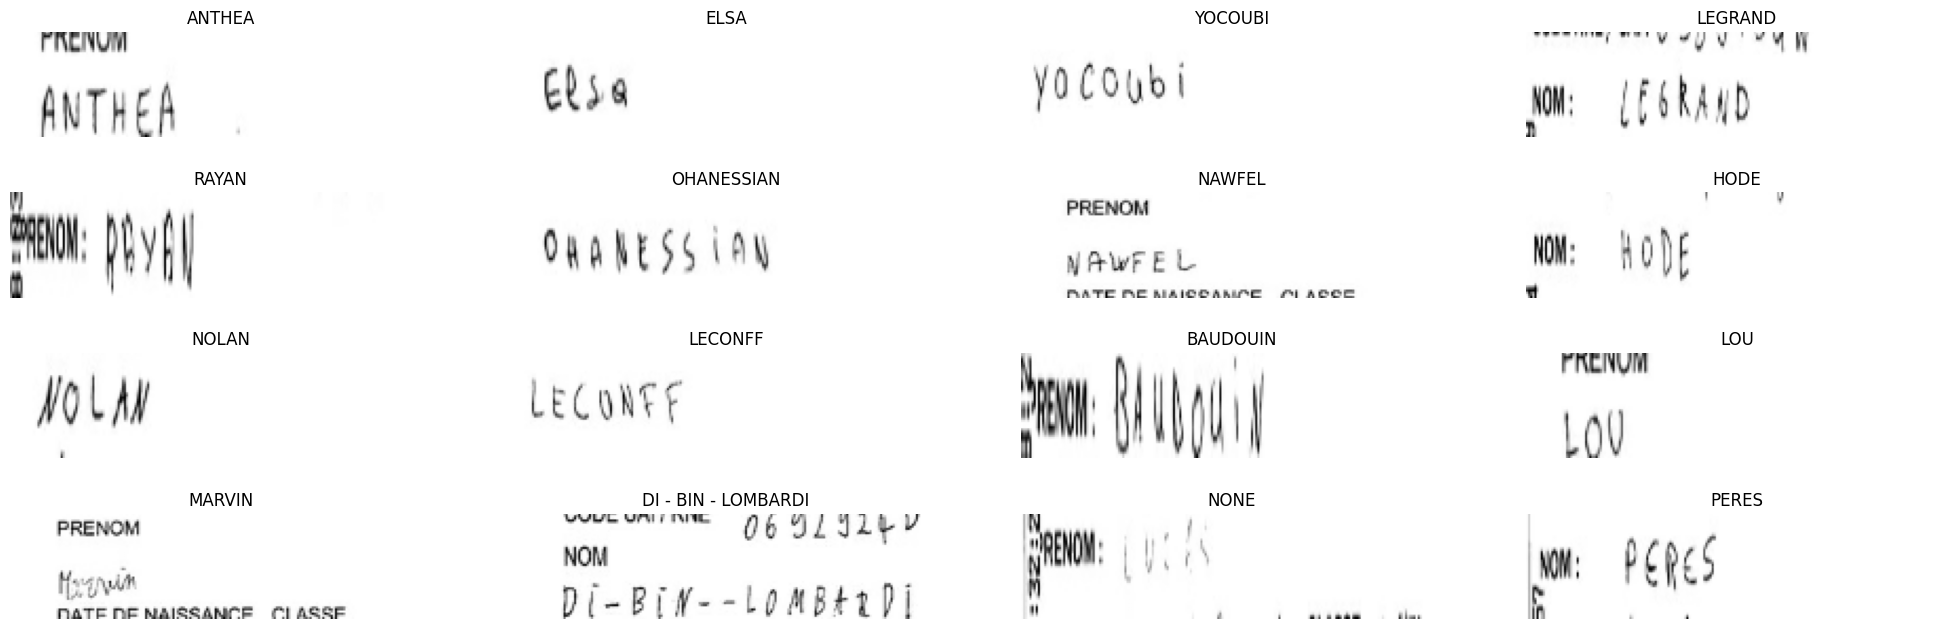

In [16]:
show_images(data=train_ds, cmap='gray')

### CTC Loss

In [17]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # Define th loss function
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # Get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype="int64") * tf.ones(shape=(batch_len, 1), dtype="int64")

        label_len = tf.cast(tf.shape(y_true)[1], dtype="int64") * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len)

        self.add_loss(loss)

        return y_hat

### Model Creation

In [ ]:
# Input Layer
input_images = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels: These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")


### Convolutional layers
# Layer 1
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)

# Layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)

# Layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)


### Encoding
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="encoding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="encoding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)


### Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)


### Final output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)


# Add the CTC loss
ctc_loss_layer = CTCLayer()(input_labels, output)

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

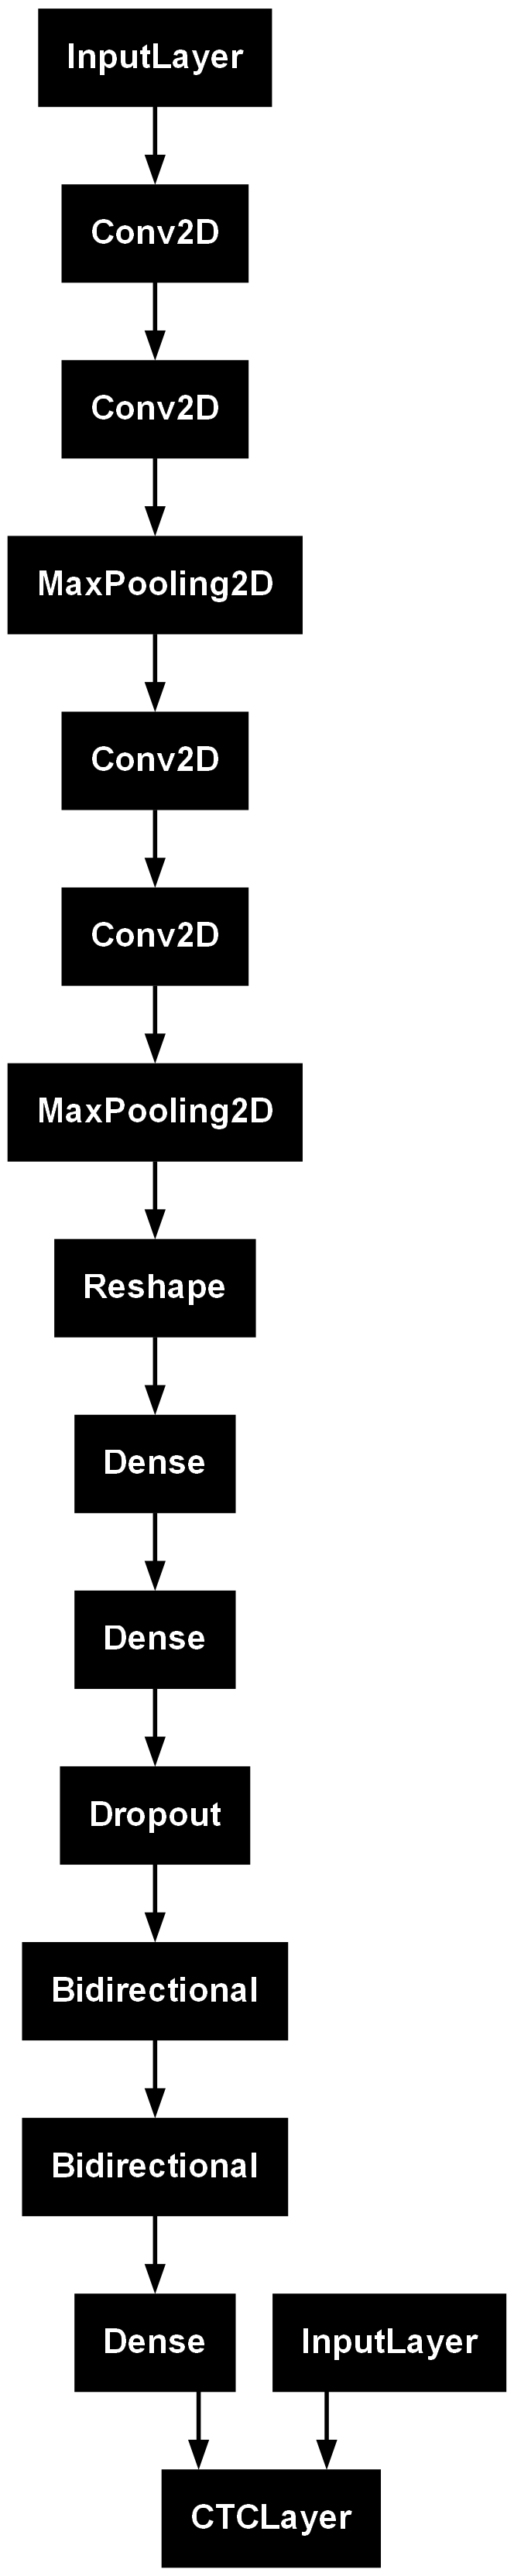

In [ ]:
# Draw the model plot
tf.keras.utils.plot_model(
    model,
    to_file="model-graph.png"
)   

In [ ]:
# See the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 50,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 50,   │     18,464 │ conv_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 100, 25,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 25,   │     18,464 │ conv_3[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ conv_4[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 50, 384)   │          0 │ max_pooling2d_1[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding_dense      │ (None, 50, 64)    │     24,640 │ reshape_layer[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding_dense_2    │ (None, 50, 64)    │      4,160 │ encoding_dense[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ encoding_dense_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 128)   │    164,352 │ bidirectional_ls… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 50, 46)    │      5,934 │ bidirectional_ls… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 50, 46)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ output_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 452,782 (1.73 MB)

 Trainable params: 452,782 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model with suitable optimizer
model.compile(optimizer="adam")

### Model Training

In [ ]:
# Train the model for 5 epochs
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS)

# Save model
model.save("ocr_model.h5")

In [38]:
# # Train the model for 5 epochs
# history = model.fit(train_ds, validation_data=valid_ds, epochs=5, callbacks=CALLBACKS)

# # Save model
# model.save("ocr_model.h5")

In [39]:
# # Reload the model
# model = tf.keras.models.load_model("ocr_model.h5", custom_objects={'CTCLayer': CTCLayer})

# # Recompile the model to reinitialize the optimizer
# model.compile(optimizer="adam")

# # Continue training from epoch 5 to 10
# history = model.fit(train_ds, validation_data=valid_ds, epochs=10, initial_epoch=5, callbacks=CALLBACKS)
# model.save("ocr_model.h5")

In [40]:
# # Reload the model
# model = tf.keras.models.load_model("ocr_model.h5", custom_objects={'CTCLayer': CTCLayer})

# # Recompile the model to reinitialize the optimizer
# model.compile(optimizer="adam")

# # Continue training from epoch 10 to 20
# history = model.fit(train_ds, validation_data=valid_ds, epochs=20, initial_epoch=10, callbacks=CALLBACKS)
# # model.save("ocr_model.h5")

In [41]:
# # Reload the model
# model = tf.keras.models.load_model("ocr_model.h5", custom_objects={'CTCLayer': CTCLayer})

# # Recompile the model to reinitialize the optimizer
# model.compile(optimizer="adam")

# # Continue training from epoch 20 to 30
# history = model.fit(train_ds, validation_data=valid_ds, epochs=30, initial_epoch=20, callbacks=CALLBACKS)
# model.save("ocr_model.h5")

In [42]:
# # Reload the model
# model = tf.keras.models.load_model("ocr_model.h5", custom_objects={'CTCLayer': CTCLayer})

# # Recompile the model to reinitialize the optimizer
# model.compile(optimizer="adam")

# # Continue training from epoch 30 to 50
# history = model.fit(train_ds, validation_data=valid_ds, epochs=50, initial_epoch=30, callbacks=CALLBACKS)
# model.save("ocr_model.h5")

### Results

In [ ]:
sb.set()
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.legend(fontsize = 15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()

In [ ]:
# Evaluate the model on the test dataset
evaluation = model.evaluate(test_ds)
print("Evaluation Loss: ", evaluation)

In [ ]:
# Define a model for testing and evaluation
pred_model = Model(inputs=input_images, output=output)

In [ ]:
'''
This function has the job to decode the prediction that the model had.
The model predicts each character and then this function makes it readable.
'''


def decoder_prediction(pred_label):
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:, :MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

### Testing

In [ ]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')

### Single sample testing

In [ ]:
'''
This function gets an image path and the model, loads and preprocesses the image and make predictions on it
'''

def single_sample_prediction(model, path):
    # Load image
    image_loading = tf.io.read_file(path)

    # Decode image
    decoded_image = tf.image.decode_jpeg(contents=image_loading, channels=1)

    # Convert the image data type to float
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    resized_image = tf.transpose(resized_image, perm=[1, 0, 2])

    # Convert image to array
    image_array = tf.cast(resized_image, dtype=tf.float32)

    # Reshape image
    single_image_data_with_batch = np.expand_dim(image_array, axis=0)

    # Make Prediction
    prediction = decoder_prediction(model.predict(single_image_data_with_batch))

    return prediction

In [ ]:
img_2_path = r"D:\Projects\Handwritten OCR\Dataset\test_v2\test\TEST_0004.jpg"

img_2 = implt.imread(img_2_path)
plt.imshow(img_2)
print(single_sample_prediction(pred_model, img_2_path))